In [1]:
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
import ipywidgets as ipywidg
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
import math
import time
import seaborn as sns
import scipy.optimize as optimize
%matplotlib inline
import matplotlib.pylab as pylab
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

import os


#My modules
from Oracle_problems import *
from GKLBi_diagonalization import GKL_
from plotting import *
from Current_oracle import *

[[1 2]
 [2 3]
 [3 5]]
V [[1. 0.]
 [0. 1.]]
U [[ 0.26726124  0.77151675]
 [ 0.53452248 -0.6172134 ]
 [ 0.80178373  0.15430335]]
ULV [[1. 2.]
 [2. 3.]
 [3. 5.]]
[[ 1.00000000e+00  5.20361465e-17 -3.73145497e-16 -3.59626182e-13]
 [ 0.00000000e+00  4.78364873e-01 -1.84393365e-01 -8.58583796e-01]
 [ 0.00000000e+00  7.65383797e-01 -3.91785738e-01  5.10579650e-01]
 [ 0.00000000e+00  4.30528386e-01  9.01389495e-01  4.62848408e-02]]
[[2.44948974e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.53424474e+00 2.39078768e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.30871044e+00 7.01390558e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.06242284e-01 1.30727101e-11]]
[[ 0.40824829  0.81649658  0.40824829]
 [ 0.26344752 -0.53356459  0.80368167]
 [-0.87403017  0.22054967  0.43293083]
 [-0.45962579 -0.62978056 -0.62619532]]


Внизу приведены примеры для нескольких случаев

## Three squares

$$x_{k+1} = \underset{y \in R^n}{argmin}\left(\frac{L}{2}||y - x_k||^2 + \frac{1}{2f_1(x_k)}\left[f_1^2(x_k) + ||F(x_k) + F'(x_k)(y - x_k)||^2\right]\right) $$

$$ T_{i_k} = (F'^TF + L2^{i_k}f_1(x))^{-1} \cdot (L2^{i_k}f_1(x)x + F'^TF'x  - F'^TF)$$

In [2]:
def TS_relaxation(x, L,f, grad_f, U, B, V):
    #i_arange = [0, 100]
    
    i = 0
    while(True):
        
        T_1 = V.T.dot(np.linalg.inv(L * 2**(i) * np.linalg.norm(f, 2) * np.eye(x.shape[0]) + B.T.dot(B)).dot(V))
        T_2 = V.T.dot(L * 2**(i) * np.linalg.norm(f, 2) * np.eye(x.shape[0]) + B.T.dot(B)).dot(V)
        T_3 = grad_f.T.dot(f)
        #print(T_1.shape)
        #print(T_2.shape)
        #print(T_3.shape)
        T_i = T_1.dot((T_2.dot(x) - T_3).T)
        
        #print(np.linalg.norm(F_Rozenbrock(T_i), 2) <= psi_operator(T_i, x, 2**(i) * L, grad_f))
        #print(i_arange)
        if(np.linalg.norm(F_Rozenbrock(T_i), 2) <= psi_operator(T_i, x, f, 2**(i) * L, grad_f)):
            #i_arange[1] = i
            return T_i, 2**(i - 1) * L
        else:
            i += 1
            #i_arange[0] = i
        #if(i_arange[1] < 1e-7):
        #    i_arange[1] = i_arange[0]
        #i = (i_arange[1] + i_arange[0]) / 2
        #i = round(i * 1e7) / 1e7
        #if(math.floor(i_arange[1] * 1e6) == math.floor(i_arange[0] * 1e6)):
            #return T_i, 2**(i - 1) * L
        


def three_squares(x_0, max_iter = 2):
    #initialization
    start_time1 = time.time()
    num_iter = 0
    x_convergence = []
    L_convergence = []
    x = x_0
    L = 1
    time_convergence = []
    time_convergence.append(0)
    L_convergence.append(L)
    x_convergence.append(x)
    while(num_iter < max_iter):
        num_iter += 1
        
        grad_F = grad_F_Rozenbrock(x)
        U_k, B_k, V_k = GKL_(grad_F)
        
        T, L = TS_relaxation(x, L, F_Rozenbrock(x), grad_F, U_k, B_k, V_k)
        T = np.squeeze(np.asarray(T))
        
        x_convergence.append(T)
        L_convergence.append(L)
        
        if(np.linalg.norm(x - T, 2) <= 1e-6):
            return x_convergence, L_convergence, time_convergence, num_iter
        
        x = T
        cur_time1 = time.time()
        time_convergence.append(cur_time1 - start_time1)
    #print()
    time_convergence.append(cur_time1 - start_time1)
    return x_convergence, L_convergence, time_convergence, max_iter

### Example f(x) - Rozenbrock

In [3]:
"""
Function F and its gradient
"""


    

grad_F_Rozenbrock(np.array([1, 1, 1, 1, 1]))

F_Rozenbrock(np.zeros((5)))

array([-1.,  1.,  1.,  1.,  1.])

In [4]:
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
x0 = np.array([-1,1, 1, 1], dtype = np.float64)
step_size = 0.1



grad_Rozenbrock_for_gd(np.array([1, 1, 1, 1, 1]))


gradient_descent = methods.fo.GradientDescent(F_Rozenbrock_for_gd, grad_Rozenbrock_for_gd, ss.ConstantStepSize(step_size))
sol = gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)

Maximum iteration exceeds!


In [5]:
methods.fo.GradientDescent?

In [6]:
x_convergence_gd = gradient_descent.get_convergence()

In [7]:
#x_convergence_gd

In [8]:
gradient_descent_Armijo = methods.fo.GradientDescent(F_Rozenbrock_for_gd, grad_Rozenbrock_for_gd, 
            ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.))
sol = gradient_descent_Armijo.solve(x0, tol = 1e-6, max_iter = 1000)
x_convergence_gd_Armijo = gradient_descent_Armijo.get_convergence()

Maximum iteration exceeds!


In [9]:
#x_convergence_gd_Armijo

### Levenberg Marquardt 

In [10]:
def Levenberg_Marquardt(f, Jac, x, lam, rho_min, rho_max, tol, max_iter = 100):
    start_time1 = time.time()
    n = x.shape[0]
    t = 1e-3
    conv = [x]
    time_convergence = [0]
    rho_max = 2
    k = 0
    while True:
        k += 1
        J = Jac(x) #Sooner will be added function of Jac
        F = f(x)
        A = J.T.dot(J)
        rho_min = t * np.amax(np.diagonal(A))
        while True:
            p = np.linalg.solve(J.T.dot(J) + lam * np.eye(n), -J.T.dot(F)) # Calculate the direction
            #alpha = StepSizeSelection(x, p, f, J)
            
            x_next = x + p
            
            F_next = f(x_next)
            
            if np.linalg.norm(F_next) < np.linalg.norm(F):
                lam *= rho_min
                
                x = x_next
                conv.append(x)
                
                break
            else:
                lam *= rho_max
            if lam>25000: #Костыль на переполнение
                x = x_next
                conv.append(x)
                break
        if np.linalg.norm(F) - np.linalg.norm(F_next) < tol:
            
            break
        if k >= max_iter:
            print("Max_iter reached")
            break
        cur_time1 = time.time()
        time_convergence.append(cur_time1 - start_time1)
    cur_time1 = time.time()
    time_convergence.append(cur_time1 - start_time1)
    return conv, time_convergence

In [11]:
n = 4
lam=0.1
x_0 = np.ones(n)
x_0[0] = -1
x_true = np.ones(n)
tol=1e-25
x_convergence_LM=Levenberg_Marquardt(F_Rozenbrock, grad_F_Rozenbrock, x_0, lam = lam, rho_min = None, rho_max = None, tol = tol, max_iter = 10000) #*args = [n, m], kwargs)

In [12]:
n = 7
lam=0.1
x_0 = np.ones(n)
x_0[0] = -1
x_true = np.ones(n)
tol=1e-25
x_convergence_LM=Levenberg_Marquardt(F_Rozenbrock, grad_F_Rozenbrock, x_0, lam = lam, 
                                     rho_min = None, rho_max = None, tol = tol, max_iter = 10000) #*args = [n, m], kwargs)

In [ ]:
n = 9
lam=0.1
x_0 = np.ones(n)
x_0[0] = -1
x_true = np.ones(n)
tol=1e-25
x_convergence_LM=Levenberg_Marquardt(F_Rozenbrock, grad_F_Rozenbrock, x_0, lam = lam, 
                                     rho_min = None, rho_max = None, tol = tol, max_iter = 10000) #*args = [n, m], kwargs)

In [ ]:
plt.loglog([np.linalg.norm(F_Rozenbrock(x) - F_Rozenbrock(x_true)) for x in x_convergence_LM])

### Stochastic squares

In [ ]:
def  StochasticSquares(x_, p_, oracle):
    start_time1 = time.time()
    iter_max = 1000000
    iter_counter = 0
    oracle_counter = 0
    func_res = []
    x_convergence = []
    grad_mapping = []
    time_convergence = []
    p = p_
    I_p = np.identity(p)
    I_n = np.identity(oracle.n)
    L = 1
    eps = 1e-6
    x_new = x_
    x_curr = x_
    func_res.append(oracle.hat_f1(x_new))

    while ((iter_counter <= iter_max) and (np.linalg.norm(x_new - x_curr, ord=2) > eps)) or (iter_counter == 0):
        cur_time1 = time.time()
        time_convergence.append(cur_time1 - start_time1)
#        print(x_curr)     
        x_curr = x_new.copy()
        x_convergence.append(x_new)
        J_curr = oracle.jacobian_F(x_curr)
        a = np.sort(np.random.choice(range(J_curr.shape[0]), size=p, replace=False))
#        print(a)
        G_curr = J_curr[a, :].T
        g_curr = oracle.grad_hat_f1(x_curr)
        f_curr = oracle.hat_f1(x_curr)
        gamma_curr = 1 / (p * f_curr)
        while True:
            B_curr = (I_n - gamma_curr / L * G_curr @ np.linalg.inv(I_p + gamma_curr / L * G_curr.T @ G_curr) @ G_curr.T) / L
            x_new = x_curr - B_curr @ g_curr
            f_new = oracle.hat_f1(x_new)
            oracle_counter = oracle_counter  + 1

            if (f_new <= f_curr
                  + g_curr @ (x_new - x_curr)
                  + 1 / (2 * p * f_curr) * np.linalg.norm(G_curr.T @ (x_new - x_curr), ord=2) ** 2
                  + L / 2 * np.linalg.norm(x_new - x_curr, ord=2) ** 2):
                 
                func_res.append(f_new)
                grad_mapping.append(np.linalg.norm(x_new - x_curr, ord=2))    
                iter_counter = iter_counter + 1
#                print('iter = ', iter_counter)
                L = L / 2

                break
        
            else:
                L = 2 * L
    x_convergence.append(x_new)
    start_time2 = time.time()
#    print(iter_counter, '.......', oracle_counter, '.......', min(grad_mapping),
#         '.......', min(func_res))
#    print(x_new)
    return np.array(x_convergence), np.array(time_convergence), iter_counter, oracle_counter, min(grad_mapping), min(func_res), (start_time2 - start_time1)

In [ ]:
x_0 = np.array([-1, 1, 1, 1, 1, 1, 1, 1, 1])
x_convergence, _, num_iter = three_squares(x_0, max_iter= 175)

In [ ]:
#x_convergence

In [ ]:
num_iter

### Случай $n = 2$

In [ ]:
#Запуск алгоритмов
n = 2
x0 = np.ones(n)
x0[0] = -1
x_true = np.ones(n)
time_convergence_TS = []

#solution_gd = gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)
x_convergence, _, time_convergence_TS, num_iter = three_squares(x0, max_iter= 1000)
#LM_convergence = Levenberg_Marquardt(F_Rozenbrock, grad_F_Rozenbrock, x0, lam = lam, rho_min = None, rho_max = None, tol = tol, max_iter = 1000)

### Случай $n = 4$

In [ ]:
from plotting import *

n = 4
p1 = 2
p2 = n - 1
x0 = np.ones(n)
x0[0] = -1
x_true = np.ones(n)

step_size = 0.1

oracle = Oracle_Chebyshev_Oscillator(n)
repeats = 1
iter_counter = np.zeros(repeats)
oracle_counter = np.zeros(repeats)
x_convergence_SS = np.zeros(repeats)
times = np.zeros(repeats)
mapping = np.zeros(repeats)
func = np.zeros(repeats)
for i in range(repeats):
    x_convergence_SS_p1, time_convergence_SS_p1, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x0, p1, oracle)
    x_convergence_SS_p2, time_convergence_SS_p2, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x0, p2, oracle)
gradient_descent = methods.fo.GradientDescent(F_Rozenbrock_for_gd, grad_Rozenbrock_for_gd, ss.ConstantStepSize(step_size))
sol = gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)
x_convergence_TS, _, time_convergence_TS, num_iter = three_squares(x0, max_iter= 10000)
x_convergence_LM, time_convergence_LM =Levenberg_Marquardt(F_Rozenbrock, grad_F_Rozenbrock, x0, lam = 0.1, 
                                     rho_min = None, rho_max = None, tol = 1e-7, max_iter = 10000) #*args = [n, m], kwargs)
plot_dict = {"TS": [x_convergence_TS[:-1], time_convergence_TS], 
             "LM": [x_convergence_LM, time_convergence_LM],
             "SimpleGD": [gradient_descent.get_convergence(), None],
             f"SS p = {p1}": [x_convergence_SS_p1[:-1], time_convergence_SS_p1],
             f"SS p = {p2}": [x_convergence_SS_p2[:-1], time_convergence_SS_p2]}

In [ ]:
plot_time_depend(plot_dict, n, grad_Rozenbrock_for_gd)
plot_iter_depend_grad(plot_dict, n, grad_Rozenbrock_for_gd)
plot_iter_depend_delta(plot_dict, x_true, n)
plot_iter_depend_norm(plot_dict, n, F_Rozenbrock)

### Случай $n= 7$

In [ ]:
#Запуск алгоритмов
n = 7
p1 = 2
p2 = n - 1
x0 = np.ones(n)
x0[0] = -1
x_true = np.ones(n)

step_size = 0.1

oracle = Oracle_Chebyshev_Oscillator(n)
repeats = 1
iter_counter = np.zeros(repeats)
oracle_counter = np.zeros(repeats)
x_convergence_SS = np.zeros(repeats)
times = np.zeros(repeats)
mapping = np.zeros(repeats)
func = np.zeros(repeats)
for i in range(repeats):
    x_convergence_SS_p1, time_convergence_SS_p1, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x0, p1, oracle)
    x_convergence_SS_p2, time_convergence_SS_p2, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x0, p2, oracle)
gradient_descent = methods.fo.GradientDescent(F_Rozenbrock_for_gd, grad_Rozenbrock_for_gd, ss.ConstantStepSize(step_size))
sol = gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)
x_convergence_TS, _, time_convergence_TS, num_iter = three_squares(x0, max_iter= 10000)
x_convergence_LM, time_convergence_LM =Levenberg_Marquardt(F_Rozenbrock, grad_F_Rozenbrock, x0, lam = 0.1, 
                                     rho_min = None, rho_max = None, tol = 1e-7, max_iter = 10000) #*args = [n, m], kwargs)
plot_dict = {"TS": [x_convergence_TS[:-1], time_convergence_TS], 
             "LM": [x_convergence_LM, time_convergence_LM],
             "SimpleGD": [gradient_descent.get_convergence(), None],
             f"SS p = {p1}": [x_convergence_SS_p1[:-1], time_convergence_SS_p1],
             f"SS p = {p2}": [x_convergence_SS_p2[:-1], time_convergence_SS_p2]}

In [ ]:
plot_time_depend(plot_dict, n, grad_Rozenbrock_for_gd)
plot_iter_depend_grad(plot_dict, n, grad_Rozenbrock_for_gd)
plot_iter_depend_delta(plot_dict, x_true, n)
plot_iter_depend_norm(plot_dict, n, F_Rozenbrock)

## Случай $n = 9$

In [ ]:
#Запуск алгоритмов
n = 9
p1 = 2
p2 = n - 1
x0 = np.ones(n)
x0[0] = -1
x_true = np.ones(n)

step_size = 0.1

oracle = Oracle_Chebyshev_Oscillator(n)
repeats = 1
iter_counter = np.zeros(repeats)
oracle_counter = np.zeros(repeats)
x_convergence_SS = np.zeros(repeats)
times = np.zeros(repeats)
mapping = np.zeros(repeats)
func = np.zeros(repeats)
for i in range(repeats):
    x_convergence_SS_p1, time_convergence_SS_p1, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x0, p1, oracle)
    x_convergence_SS_p2, time_convergence_SS_p2, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x0, p2, oracle)
gradient_descent = methods.fo.GradientDescent(F_Rozenbrock_for_gd, grad_Rozenbrock_for_gd, ss.ConstantStepSize(step_size))
sol = gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)
x_convergence_TS, _, time_convergence_TS, num_iter = three_squares(x0, max_iter= 10000)
x_convergence_LM, time_convergence_LM =Levenberg_Marquardt(F_Rozenbrock, grad_F_Rozenbrock, x0, lam = 0.1, 
                                     rho_min = None, rho_max = None, tol = 1e-7, max_iter = 1e6) #*args = [n, m], kwargs)
plot_dict = {"TS": [x_convergence_TS[:-1], time_convergence_TS], 
             "LM": [x_convergence_LM, time_convergence_LM],
             "SimpleGD": [gradient_descent.get_convergence(), None],
             f"SS p = {p1}": [x_convergence_SS_p1[:-1], time_convergence_SS_p1],
             f"SS p = {p2}": [x_convergence_SS_p2[:-1], time_convergence_SS_p2]}

In [ ]:
plot_time_depend(plot_dict, n, grad_Rozenbrock_for_gd)
plot_iter_depend_grad(plot_dict, n, grad_Rozenbrock_for_gd)
plot_iter_depend_delta(plot_dict, x_true, n)
plot_iter_depend_norm(plot_dict, n, F_Rozenbrock)

## Случай $n = 11$

In [ ]:
#Запуск алгоритмов
n = 11
p1 = 2
p2 = n - 1
x0 = np.ones(n)
x0[0] = -1
x_true = np.ones(n)

step_size = 0.1

oracle = Oracle_Chebyshev_Oscillator(n)
repeats = 1
iter_counter = np.zeros(repeats)
oracle_counter = np.zeros(repeats)
x_convergence_SS = np.zeros(repeats)
times = np.zeros(repeats)
mapping = np.zeros(repeats)
func = np.zeros(repeats)
for i in range(repeats):
    x_convergence_SS_p1, time_convergence_SS_p1, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x0, p1, oracle)
    x_convergence_SS_p2, time_convergence_SS_p2, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x0, p2, oracle)
gradient_descent = methods.fo.GradientDescent(F_Rozenbrock_for_gd, grad_Rozenbrock_for_gd, ss.ConstantStepSize(step_size))
sol = gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)
#x_convergence_TS, _, time_convergence_TS, num_iter = three_squares(x0, max_iter= 10000)
x_convergence_LM, time_convergence_LM =Levenberg_Marquardt(F_Rozenbrock, grad_F_Rozenbrock, x0, lam = 0.1, 
                                     rho_min = None, rho_max = None, tol = 1e-7, max_iter = 1e6) #*args = [n, m], kwargs)
plot_dict = {"LM": [x_convergence_LM, time_convergence_LM],
             "SimpleGD": [gradient_descent.get_convergence(), None],
             f"SS p = {p1}": [x_convergence_SS_p1[:-1], time_convergence_SS_p1],
             f"SS p = {p2}": [x_convergence_SS_p2[:-1], time_convergence_SS_p2]}

In [ ]:
plot_time_depend(plot_dict, n, grad_Rozenbrock_for_gd)
plot_iter_depend_grad(plot_dict, n, grad_Rozenbrock_for_gd)
plot_iter_depend_delta(plot_dict, x_true, n)
plot_iter_depend_norm(plot_dict, n, F_Rozenbrock)

# Example Trigonometric Oscill f(x)

## Случай $n = 4$

In [16]:
n = 4
p1 = 2
p2 = n - 1
x0 = np.ones(n)
x0[0] = -1
x_true = np.ones(n)

step_size = 0.1

oracle = Oracle_Trigonometric_Oscillator(n)
repeats = 1
iter_counter = np.zeros(repeats)
oracle_counter = np.zeros(repeats)
x_convergence_SS = np.zeros(repeats)
times = np.zeros(repeats)
mapping = np.zeros(repeats)
func = np.zeros(repeats)
for i in range(repeats):
    x_convergence_SS_p1, time_convergence_SS_p1, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x0, p1, oracle)
    x_convergence_SS_p2, time_convergence_SS_p2, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x0, p2, oracle)
#gradient_descent = methods.fo.GradientDescent(F_Rozenbrock_for_gd, grad_Rozenbrock_for_gd, ss.ConstantStepSize(step_size))
#sol = gradient_descent.solve(x0, tol = 1e-6, max_iter = 1000)
#x_convergence_TS, _, time_convergence_TS, num_iter = three_squares(x0, max_iter= 10000)
x_convergence_LM, time_convergence_LM =Levenberg_Marquardt(F_Trigonom, jacobian_F, x0, lam = 0.1, 
                                     rho_min = None, rho_max = None, tol = 1e-7, max_iter = 10000) #*args = [n, m], kwargs)
plot_dict = {"LM": [x_convergence_LM, time_convergence_LM],
             f"SS p = {p1}": [x_convergence_SS_p1[:-1], time_convergence_SS_p1],
             f"SS p = {p2}": [x_convergence_SS_p2[:-1], time_convergence_SS_p2]}

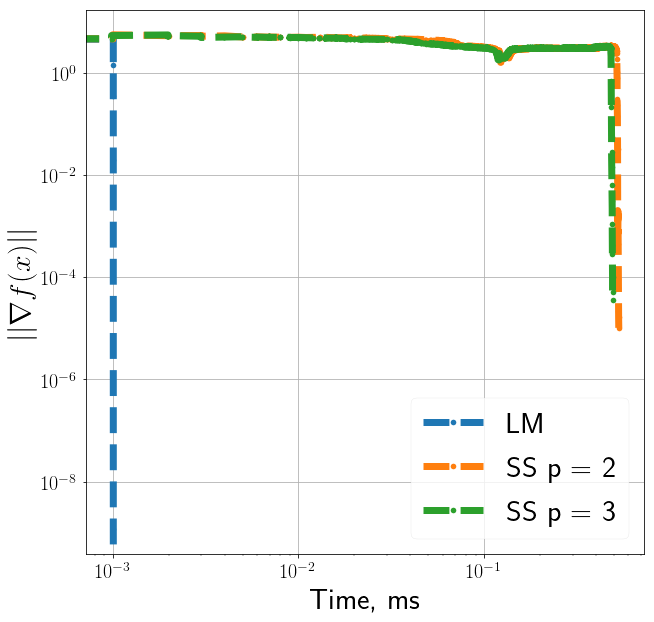

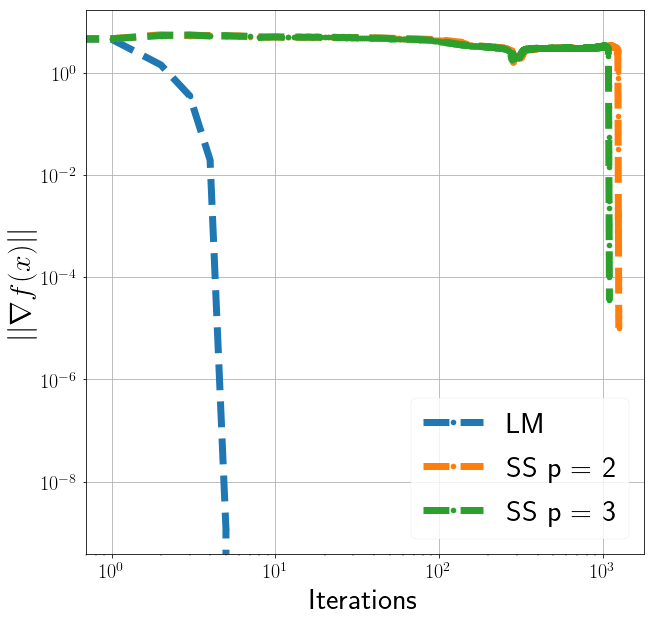

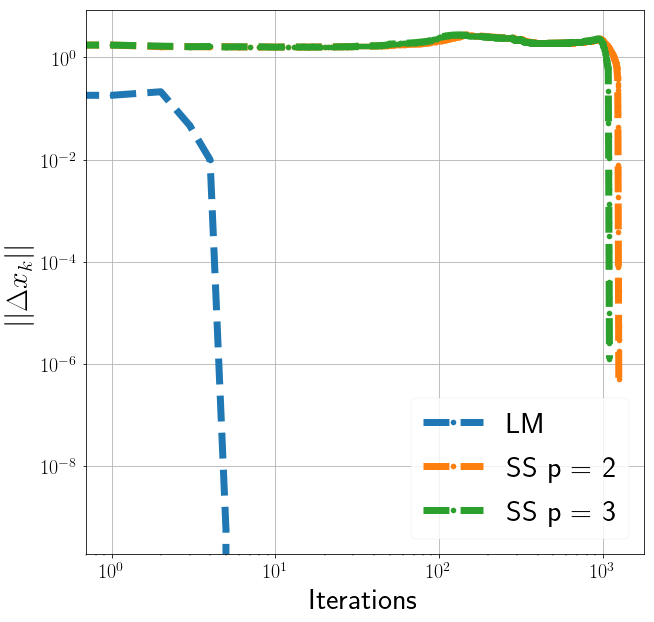

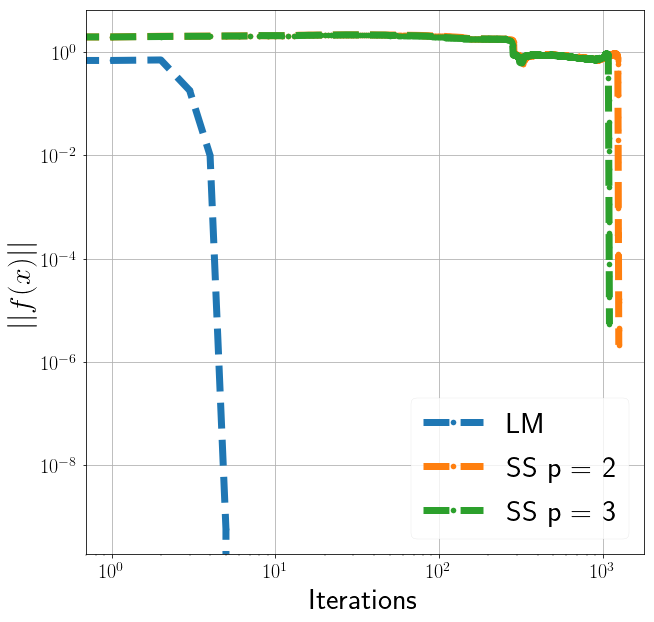

In [17]:
plot_time_depend(plot_dict, n, grad_Rozenbrock_for_gd, 2)
plot_iter_depend_grad(plot_dict, n, grad_Rozenbrock_for_gd, 2)
plot_iter_depend_delta(plot_dict, x_true, n, 2)
plot_iter_depend_norm(plot_dict, n, F_Rozenbrock, 2)

## Normalize Squares

In [ ]:
def Normalized_f(x):
    return 1/x.shape[0]**(0.5) * F_Rozenbrock(x)


## Stochastic Squares

In [ ]:
n = 4
p = 2
x_0 = np.ones(n)
x_0[0] = -1

oracle = Oracle_Trigonometric_Oscillator(n)
repeats = 1
iter_counter = np.zeros(repeats)
oracle_counter = np.zeros(repeats)
x_convergence_SS = np.zeros(repeats)
times = np.zeros(repeats)
mapping = np.zeros(repeats)
func = np.zeros(repeats)
for i in range(repeats):
    x_convergence_SS, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x_0, p, oracle)
    

print('iter_counter = ', np.mean(iter_counter))
print('oracle_counter = ', np.mean(oracle_counter))
print('grad_mapping = ', np.mean(mapping))
print('func = ', np.mean(func))
print('time = ', np.mean(times))

In [ ]:
x_convergence_SS

In [ ]:
plt.loglog([np.linalg.norm(oracle.F(x) - oracle.F(x_true)) for x in x_convergence_SS])

In [ ]:
x_convergence_SS

In [ ]:
n = 10
p = 10
x_0 = np.ones(n)
x_0[0] = -1
x_true = np.ones(n)
oracle = Oracle_Chebyshev_Oscillator(n)
repeats = 1
x_convergence_SS = []
iter_counter = np.zeros(repeats)
oracle_counter = np.zeros(repeats)
times = np.zeros(repeats)
mapping = np.zeros(repeats)
func = np.zeros(repeats)
for i in range(repeats):
    x_convergence_SS, iter_counter[i], oracle_counter[i], mapping[i], func[i], times[i] = StochasticSquares(x_0, p, oracle)

    

print('iter_counter = ', np.mean(iter_counter))
print('oracle_counter = ', np.mean(oracle_counter))
print('grad_mapping = ', np.mean(mapping))
print('func = ', np.mean(func))
print('time = ', np.mean(times))

In [ ]:
plt.loglog([np.linalg.norm(oracle.F(x) - oracle.F(x_true)) for x in x_convergence_SS])